# Índice
1. [Introdução](#introduction)  
2. [Pré-processamento dos dados](#pre-processing)  
3. [Visualização dos dados](#data-visualization)  
 3.1. [Gráficos de correalação](#corr-graphs)  
 3.2. [Comparação dos valores de target com outras features](#target-features)  

## 1. Introdução <a name="introduction"></a>
<p>Este <i>notebook</i> contém a utilização do algoritmo de regressão conhecido como [SGDRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) - Gradiente Descendente Estocástico ou do inglês <i>Stochastic Gradient Descent.</i></p>

In [67]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns; sns.set() 
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer

## 2. Pré-processamento dos dados <a name="pre-processing"></a>
<p>Todo o passo-a-passo do pré-processamento dos dados pode ser encontrado no arquivo <i>rdu-weather-history.ipynb</i>, sendo que aqui o processo será bastante semelhante, porém de maneira reduzida e com modificações para adequar melhor à situação.</p>

In [68]:
weather_history = pd.read_csv('rdu-weather-history.csv', parse_dates=['date'], sep=';')
weather_history.shape

(4137, 28)

Substituindo as string por números binários:
* No = 0.0
* Yes = 1.0

In [69]:
weather_history = weather_history.replace('No', 0.0)
weather_history = weather_history.replace('Yes', 1.0)

<p>Esse é um caso em que o pré-processamento diverge do arquivo de pré-processamento. Isso aconteceu porque a abordagem utilizando esse modelo é diferente, não dividindo o dataset por estação do ano, e sim utilizando ele todo, mas substituindo a <i>feature season</i> por <i>dummies</i>. Essa escolha foi feita devido ao <i>SGDRegressor </i> ser mais indicado para datasets grandes, passando de 10000 linhas, por isso é mais interessante aplicá-lo em um de 4000 linhas do que em 4 de aproximadamente 1000 linhas.</p>

Substituindo os valores nulos pela média dos valores referentes a feature

In [70]:
imputer = Imputer(missing_values=np.nan, strategy='median', axis=0)
weather_history[['temperaturemin']] = imputer.fit_transform(weather_history[['temperaturemin']])
weather_history[['temperaturemax']] = imputer.fit_transform(weather_history[['temperaturemax']])
weather_history[['precipitation']] = imputer.fit_transform(weather_history[['precipitation']])
weather_history[['snowfall']] = imputer.fit_transform(weather_history[['snowfall']])
weather_history[['snowdepth']] = imputer.fit_transform(weather_history[['snowdepth']])
weather_history[['avgwindspeed']] = imputer.fit_transform(weather_history[['avgwindspeed']])
weather_history[['fastest2minwinddir']] = imputer.fit_transform(weather_history[['fastest2minwinddir']])
weather_history[['fastest2minwindspeed']] = imputer.fit_transform(weather_history[['fastest2minwindspeed']])
weather_history[['fastest5secwinddir']] = imputer.fit_transform(weather_history[['fastest5secwinddir']])
weather_history[['fastest5secwindspeed']] = imputer.fit_transform(weather_history[['fastest5secwindspeed']])

Criando coluna season a partir da data

In [71]:
season_array = []
for date in weather_history['date']:
    if int(date.strftime('%m%d')) >= 1221 or int(date.strftime('%m%d')) <= 319:
        season = 'winter'
    elif int(date.strftime('%m%d')) >= 320 and int(date.strftime('%m%d')) <= 620:
        season = 'spring'
    elif int(date.strftime('%m%d')) >= 621 and int(date.strftime('%m%d')) <= 921:
        season = 'summer'
    elif int(date.strftime('%m%d')) >= 922 and int(date.strftime('%m%d')) <= 1220:
        season = 'autumn'    
    
    season_array.append(season)

weather_history = weather_history.drop(columns=['date'])
weather_history['season'] = season_array

Substituindo a coluna season por dummies

In [72]:
weather_history = weather_history
dummies = pd.get_dummies(weather_history['season'])
weather_history = weather_history.drop(columns=['season'])
dummie_weather_history = pd.concat([weather_history, dummies], axis=1)

dummie_weather_history.shape

(4137, 31)

## 3. Visualização dos dados <a name="data-visualization"></a>
<p>Assim como no pré-processamento dos dados, a visualização deles também foi feita de uma meneira um pouco diferente nesse contexto, tendo em vista que foram criadas as <i>dummies</i> e com isso o número de features aumentou.</p>

### 3.1 Gráficos de correlação <a name="corr_graphs"></a>
<p>Assim como no arquivo principal, também foi usado a biblioteca <i>Seaborn</i> para visualizações estatísticas, nesse caso com o <i>coeficiente de correlação de Pearson</i>.</p>

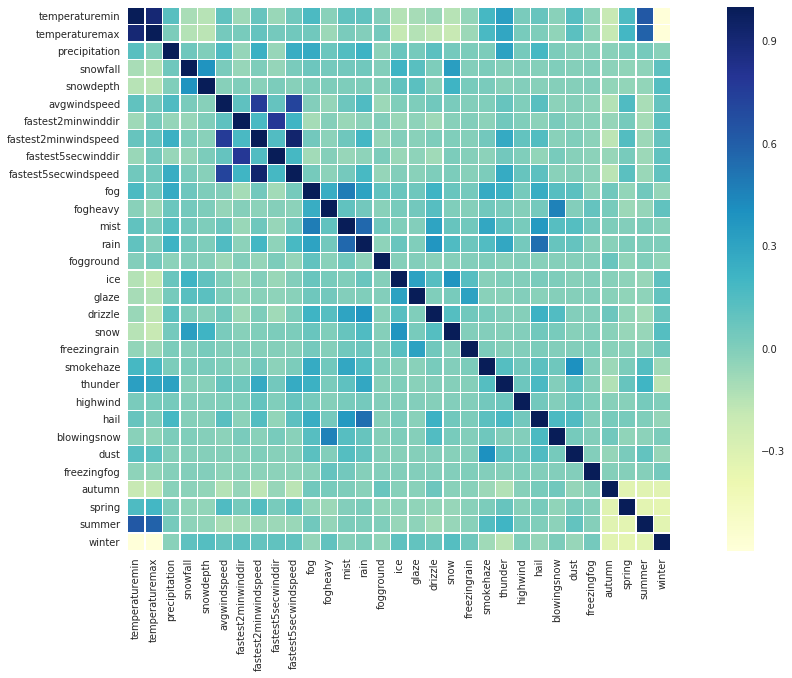

In [73]:
sns.heatmap(dummie_weather_history.corr(), square=True, cmap="YlGnBu", linewidths=.2)

Usando esse coeficiente, também foi possível plotar um gráfico da correlação das features com a feature target - *temperaturemin*, além dos valores ordenados de forma crescente.

temperaturemin          1.000000
temperaturemax          0.905429
summer                  0.628894
thunder                 0.325817
smokehaze               0.190448
fog                     0.171084
spring                  0.162112
dust                    0.133364
precipitation           0.125933
rain                    0.103727
mist                    0.102007
avgwindspeed            0.100446
hail                    0.085505
fastest2minwindspeed    0.080501
fastest5secwindspeed    0.053499
highwind                0.019096
fogground              -0.002216
blowingsnow            -0.023407
fogheavy               -0.024878
freezingfog            -0.035364
freezingrain           -0.047896
fastest5secwinddir     -0.063881
drizzle                -0.065506
fastest2minwinddir     -0.076538
glaze                  -0.101408
snowfall               -0.106544
ice                    -0.139490
snow                   -0.145840
snowdepth              -0.148192
autumn                 -0.196920
winter    

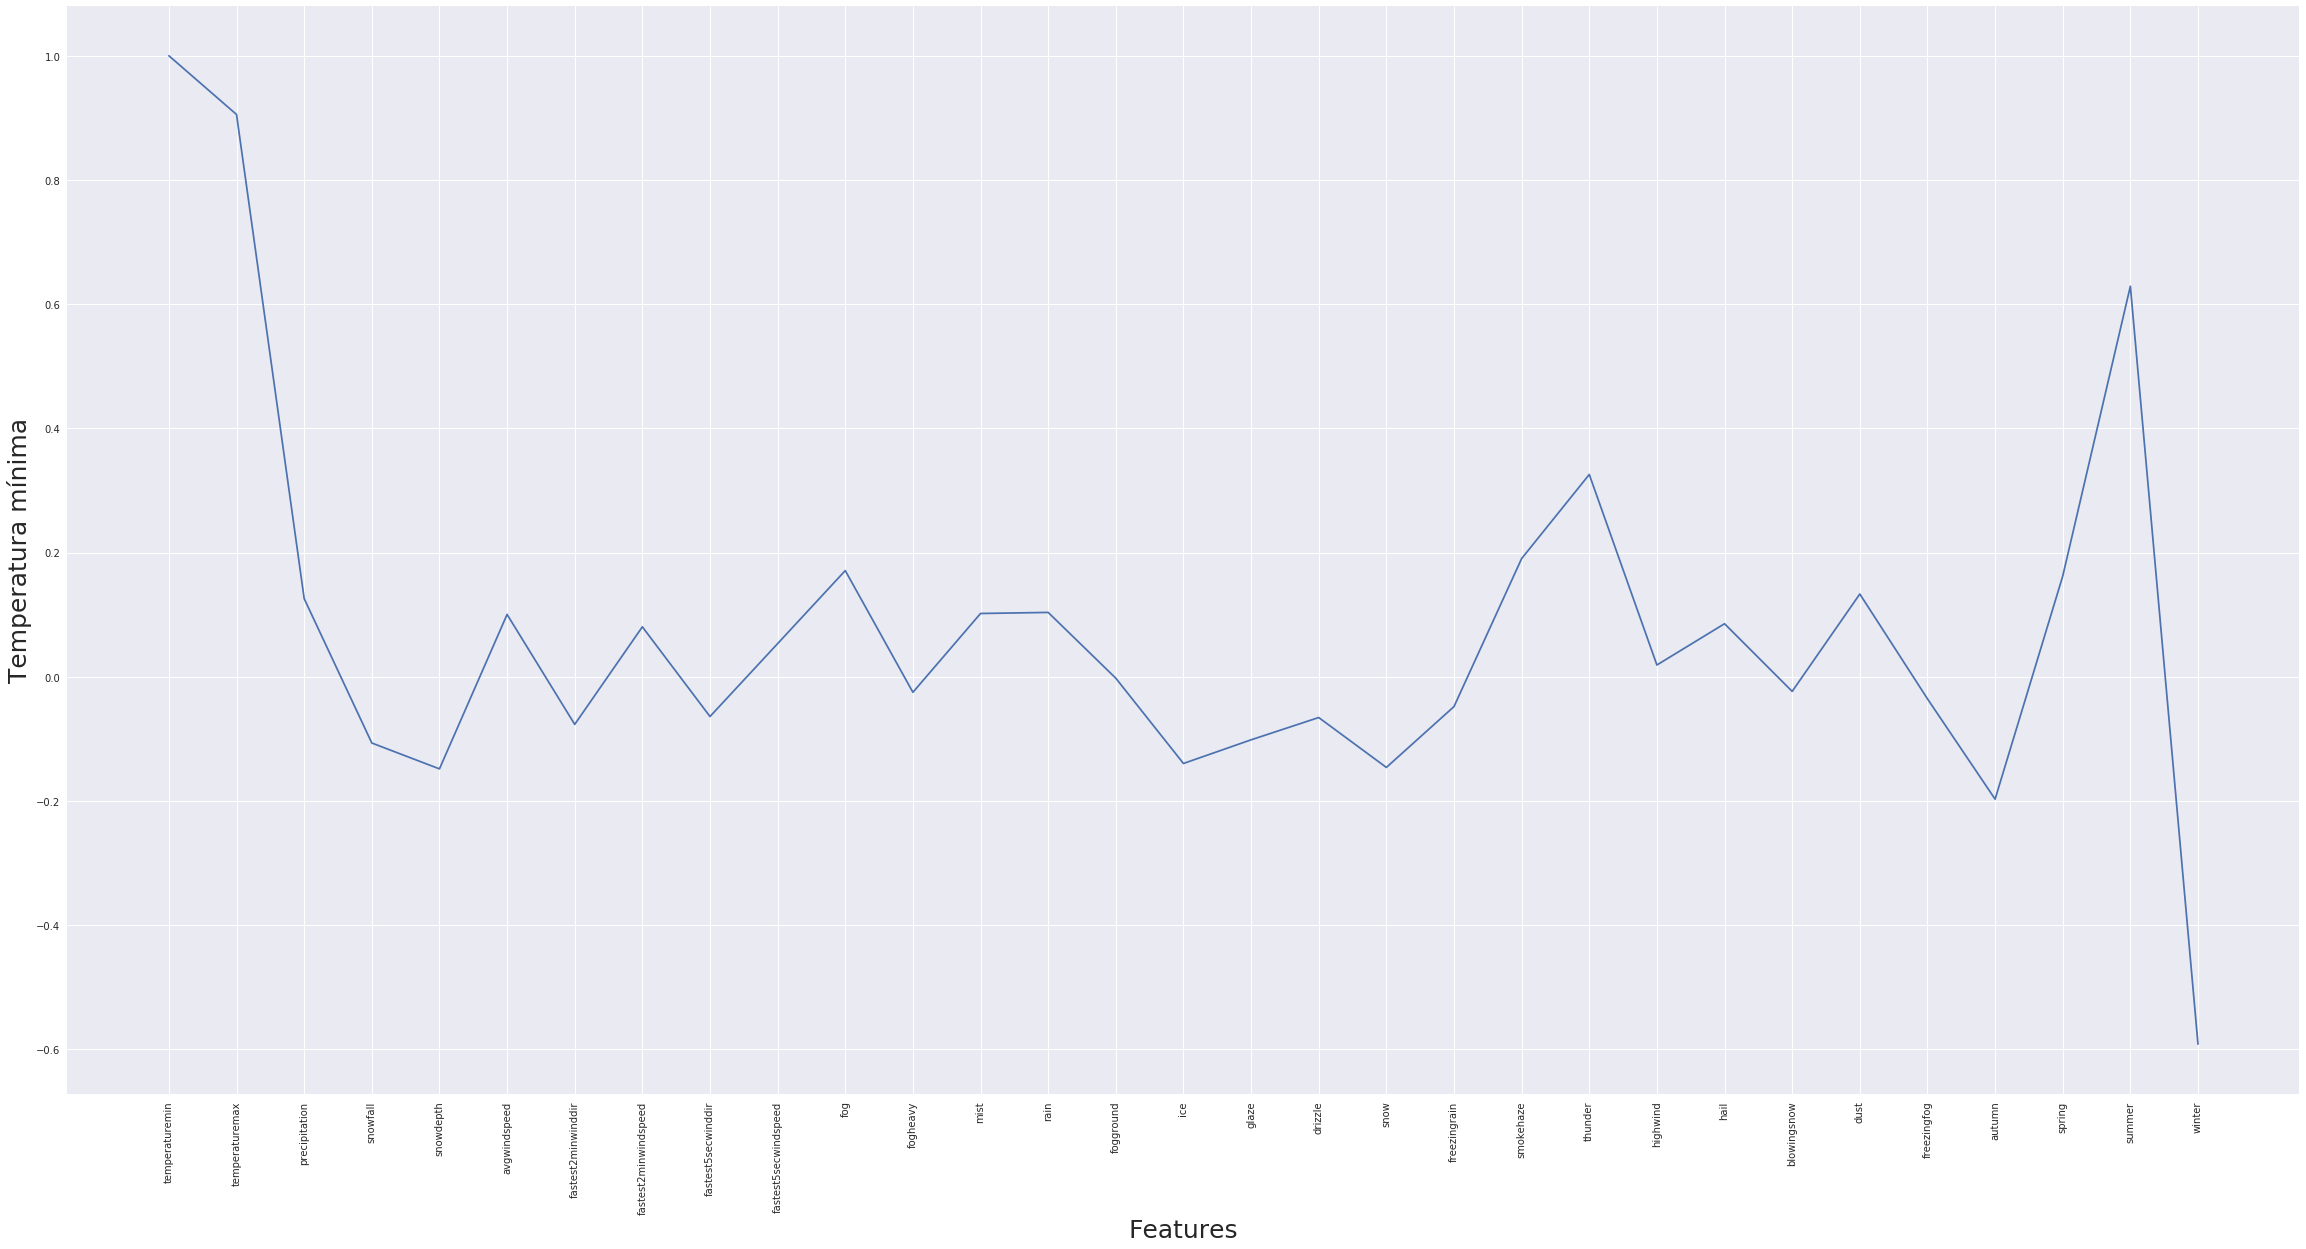

In [74]:
corr_target_features = dummie_weather_history.corr()['temperaturemin']
plt.rcParams['figure.figsize'] = [40, 20]
plt.xticks(rotation='vertical')
plt.plot(corr_target_features)
plt.ylabel('Temperatura mínima', fontsize=25)
plt.xlabel('Features', fontsize=25)
corr_target_features.sort_values(ascending=False)

É perceptível que a *feature* com o coeficiente de correlação mais alto foi o *temperaturemax*, com pouco mais 90%. Com isso, é possível dizer que, na maioria das vezes que a temperatura máxima aumenta, o mesmo acontece com a temperatura mínima. Também é interessante mostrar que *winter* tem uma correlação negativa de cerca de 59%, ou seja, no inverno a tendência da temperatura mínima tende a ser mais baixa.

### 3.2 Comparação dos valores de target com outras features <a name="target-features"></a>
<p>Uma forma de mostrar a forma que os valores de <i>target</i> se comportam em relação a outras <i>features</i> foi desenhar um gráfico onde o eixo <i>y</i> possui os valores de <b>temperatura mínima</b> e o eixo <i>x</i> os valores das outras <i>features</i>. Foram escolhidas 5 <i>features</i> para esse estudo, sendo duas que tiveram os coeficeiente de correlações mais altos positivamente e dois negativamente, além da <i>tunder</i>, escolhido de maneira arbitrária.</p>

<p>Função para facilitar o plot dos gráficos:</p>

In [75]:
y = dummie_weather_history['temperaturemin'].values

def scatter_plotting(column, x_label):
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.scatter(column, y)
    plt.ylabel('Temperatura mínima', fontsize=12)
    plt.xlabel(str(x_label), fontsize=12)

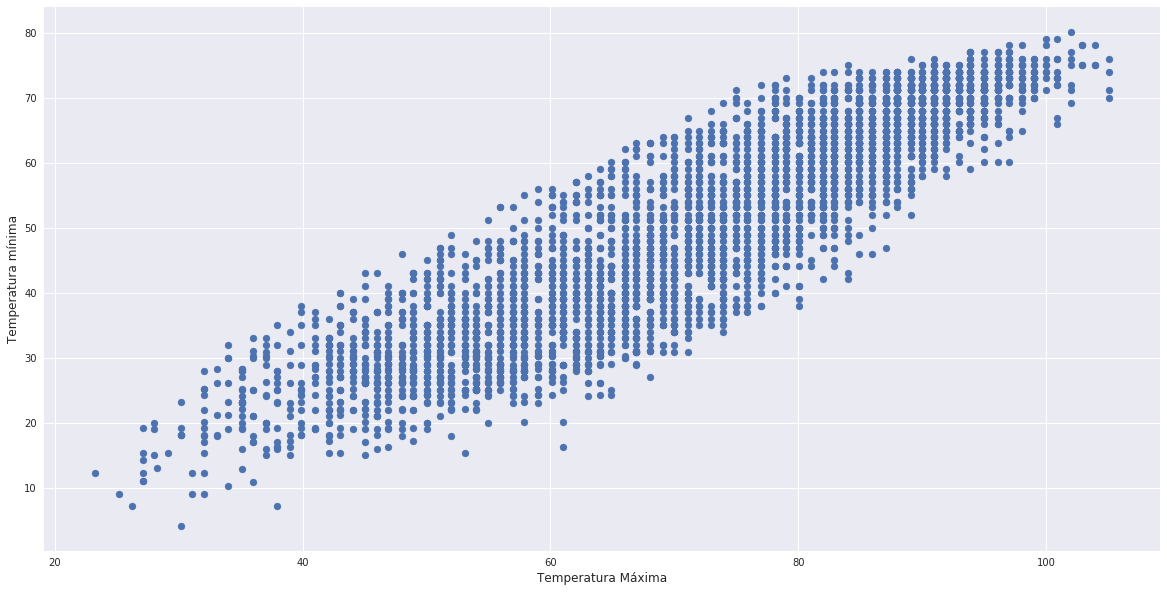

In [76]:
scatter_plotting(dummie_weather_history['temperaturemax'], 'Temperatura Máxima')

Aqui pode-se observar uma relação bem linear entre **temperatura mínima** e **temperatura máxima**, onde a tendência é uma acompanhar o crescimento da outra.

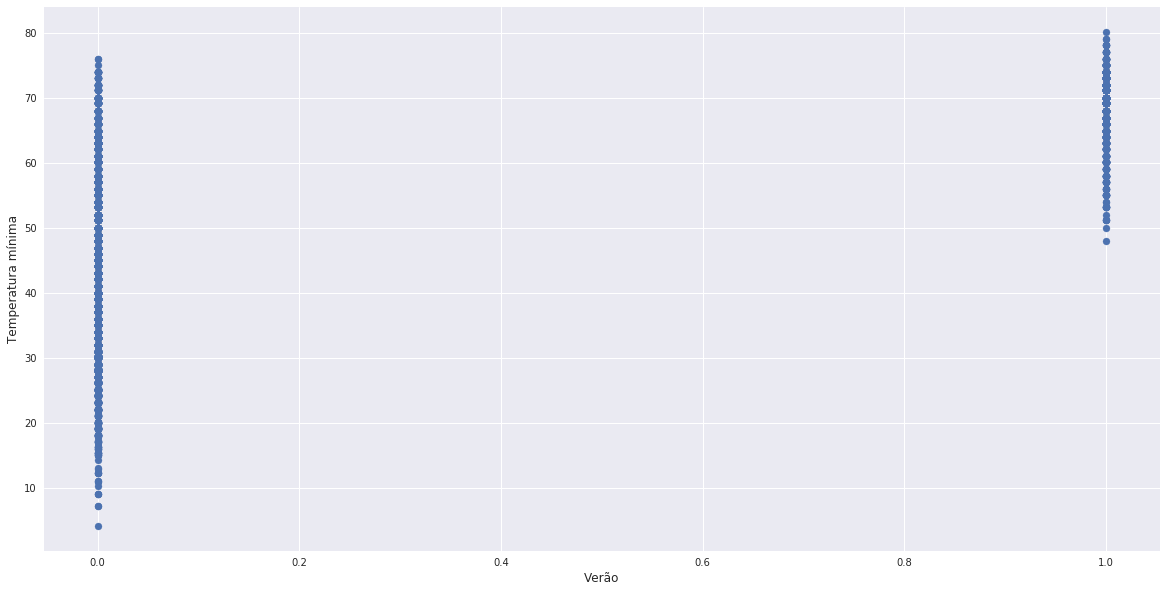

In [77]:
scatter_plotting(dummie_weather_history['summer'], 'Verão')

Quando a **temperatura mínima** é aferida no **verão**, é possível notar que ela não foi menor que pouco menos de 50°F e a maior temperatura mínima também aconteceu no verão. Isso significa que o verão tem uma influência forte na temperatura, o que está de acordo com o mundo real.

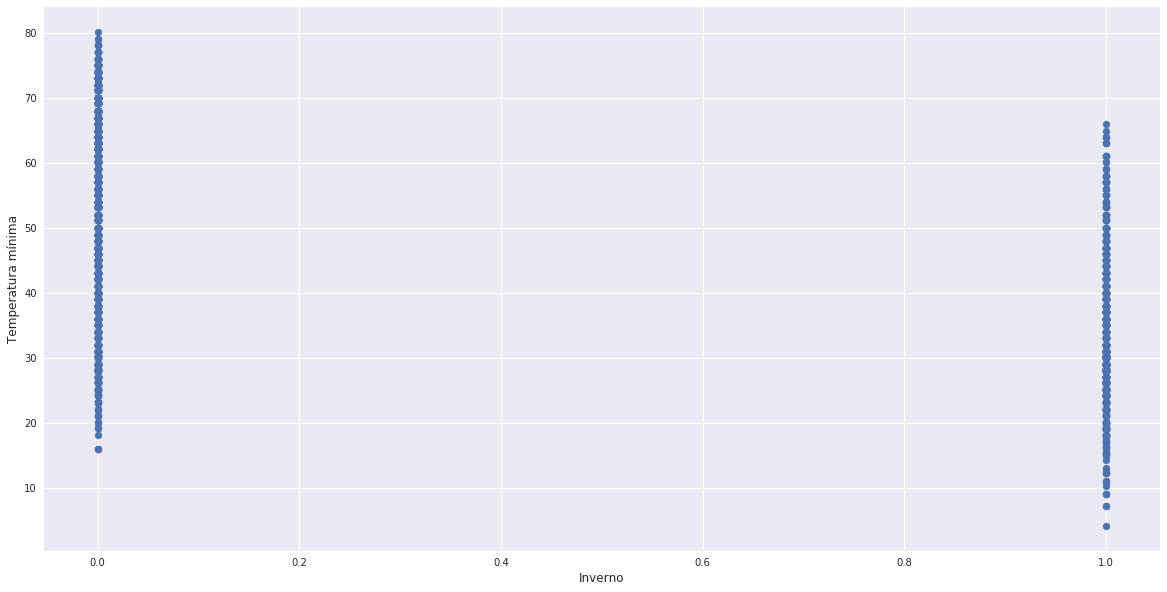

In [78]:
scatter_plotting(dummie_weather_history['winter'], 'Inverno')

O que aconteceu no verão acontece de maneira análoga no **inverno**, ou seja, os menores valores aconteceram nessa estação, além da **temperatura mínima** tender a valores menores.

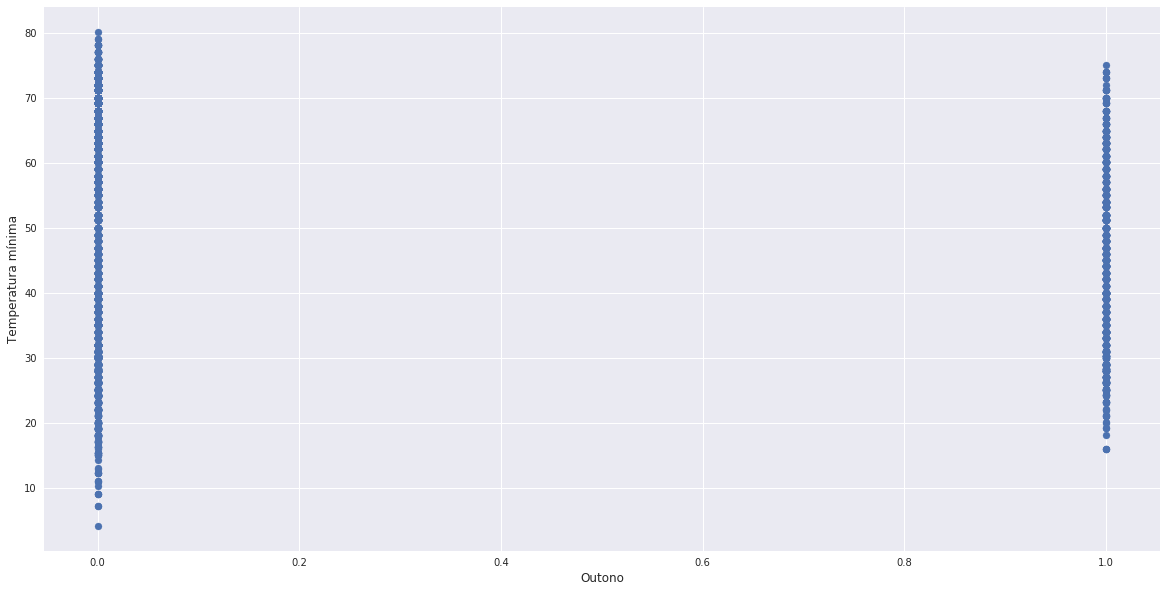

In [79]:
scatter_plotting(dummie_weather_history['autumn'], 'Outono')

No mundo real, o **outono** possui temperaturas mais amenas, por ser uma estação de transição do verão para o inverno. Isso pode ser observado pelos valores da **temperatura mínima** nunca estão nos extremos, se concentrando no meio do eixo *y*.

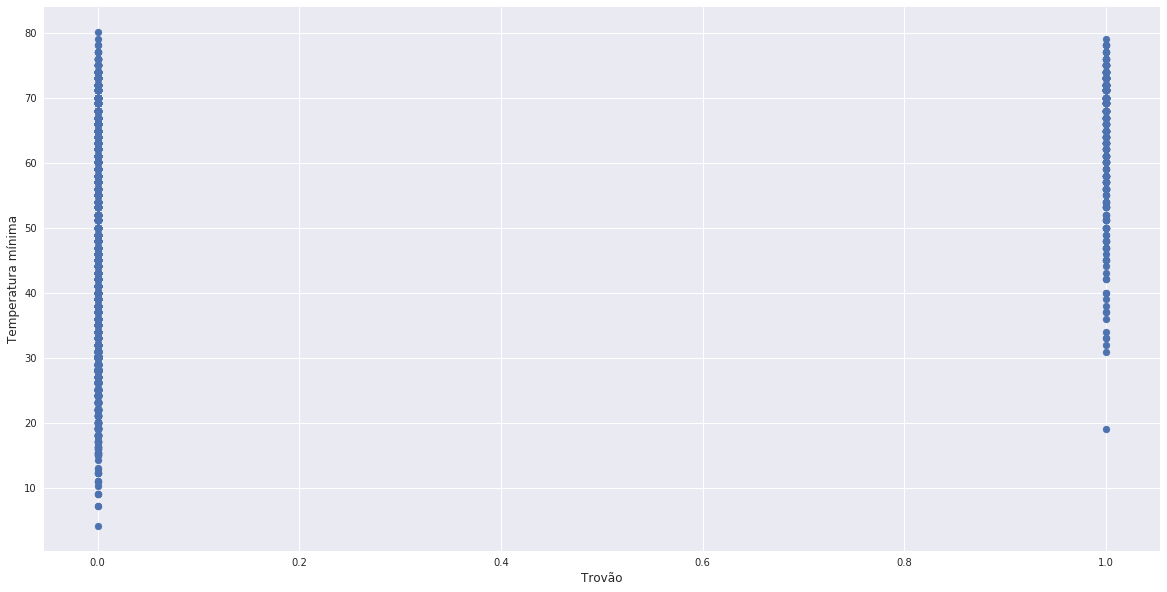

In [80]:
scatter_plotting(dummie_weather_history['thunder'], 'Trovão')

Mesmo tendo uma correlação fraca com a **temperatura mínima**, é interessante observar que a ocorrência de **trovões** ficou a frente de outras *features* que naturalmente deveriam ter correlações maiores com a *target*, como o próprio outono ou chuva.